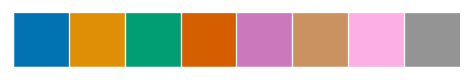

In [44]:
%matplotlib inline
import base64
from collections import namedtuple, OrderedDict
from datetime import datetime
from itertools import product
import glob
import io
import os
import pickle
import sys
os.environ['PROJ_LIB']=os.path.join(os.environ['HOME'],'.anaconda3','share','proj')

from astropy.stats import LombScargle
import astropy.units as u
from brewer2mpl import qualitative
import cufflinks as cf
import h5py
from IPython.display import HTML
import json
import matplotlib as mpl
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, cm as colmap
import mpld3
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import numpy as np
import palettable as colortable
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import pytz
import seaborn as sns
from scipy import signal
from scipy import interpolate
import tempfile
import xarray as xr
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from tint.visualization import make_mp4_from_frames, plot_traj

sns.set()
fontsize = 30
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = [15.0,10.0]
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
plt.style.use("seaborn-talk")

pal = sns.palplot(sns.color_palette("colorblind", 8))
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
sns.set_context('talk')
sns.set_palette(pal)
sns.despine()
np.warnings.filterwarnings('ignore')
utc = pytz.UTC
timezone = pytz.timezone('Australia/Darwin')
mpld3.disable_notebook()
trackfile = 'tint_tracks_2006_11_10_00-2006_11_18_23-old.pkl'
CPOL_trackdir = os.path.join(os.getenv('HOME'),'Data', 'Extremes','CPOL', 'Tracking')
CPOL_trackfile =  os.path.join(CPOL_trackdir, trackfile)
Cpol_tF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','CPOL_tracks.pkl')
#pal
paper_path = os.path.join(os.environ['HOME'], 'Work', 'Paper', '2018', 'Hector')

In [4]:
cycles = pd.read_pickle('../../slides/storm_cycle.pkl')
medians = pd.read_pickle('../../slides/medians.pkl').round(2)
medians.iloc[0] = np.sqrt(medians.iloc[0]/np.pi)

In [7]:
UM133_ens = xr.open_dataset('../UM133ens.nc')
UM044_ens = xr.open_dataset('../UM044ens.nc')
CPOL = xr.open_dataset('../CPOL.nc')
def get_quant(df, **kwargs):
    try:
        quant = kwargs['quant']
    except KeyError:
        quant={1:(0,0.2), 2:(0.2,0.4), 3:(0.4, 0.6), 4:(0.6,0.8), 5:(0.8,1)}
    try:
        rain = kwargs['rain']
    except KeyError:
        rain='avg_mean'
    for n, q in quant.items():
        Q = df[rain].quantile(q)
        df.quant.loc[(df[rain]>= Q[q[0]]) & (df[rain]<Q[q[1]]) ] = int(n)
    return df
        
        
def ravel(ens_data, run='Cpol', **kwargs):
    pdf = {}
    try:
        variables = kwargs['variables']
    except KeyError:
        variables = ['avg_area','dur', 'avg_mean', 'max_mean', 'v']
    for var in dict(ens_data[variables].variables).keys():
        if not var.startswith('dim') :
            pdf[var] = ens_data[var].values.ravel()
            pdf[var] = pdf[var][pdf[var] != np.nan]
    df = pd.DataFrame(pdf).dropna()
    run_n = [run for i in range(len(df))]
    df['run'] = run_n
    df['quant'] = np.zeros(len(df), dtype='i')
    df.index = np.arange(len(df))+1
    return get_quant(df, **kwargs)

In [9]:
h5 = pd.HDFStore('../Stormtracks.hdf', 'r')

In [52]:
track_data = {}
from collections import defaultdict

def Tree():
    return defaultdict(Tree)
def matplotlib_to_plotly(cmap, pl_entries, rgb=True):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        if rgb:
            pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        else:
            pl_colorscale.append(tuple(np.array(C)/255))

    return pl_colorscale
track_data = Tree()
for path in h5.keys():
    split =  path.split('/')[1:]
    if split[-1] != 'total':
        track_data[split[0]][split[1]][split[2]] = h5[path]

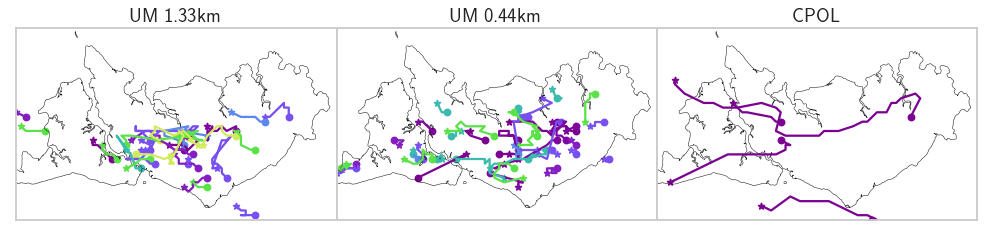

In [60]:
fig = plt.figure(figsize=(15,6))
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
fig.subplots_adjust(right=0.9, bottom=0.05, top=0.98,left=0.01, hspace=0, wspace=0.)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
o = namedtuple('Sim', 'dataset percentiles')
tmp_obs = o({'obs': h5['/CPOL/dataset/obs']}, {'obs': h5['/CPOL/percentile/obs']})
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['UM 1.33km', 'UM 0.44km', 'CPOL']
colm = matplotlib_to_plotly(CubeYF_20.get_mpl_colormap(N=8, gamma=2.0),8, rgb=False)
for i, varname in enumerate(track_data.keys()):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title(titels[i], fontsize=fontsize-10)
    for ii, tr in enumerate(track_data[varname]['dataset'].keys()):
        if ii == 0 :
            draw_map = None
            m2 = None
        else:
            draw_map = m
        #Id = [stormId.Sim[tr]]
        perc = track_data[varname]['percentile'][tr][tp][num]
        ax, m, im = plot_traj(track_data[varname]['dataset'][tr], lon, lat, ax=ax, mintrace=2, thresh=('mean', perc), 
                  color=colm[ii], create_map=draw_map, basemap_res='f', lw=0.5, size=40, particles=None)
_ = fig.savefig(os.path.join(paper_path, 'Figure_07.pdf'), bbox_set_inches='tight', dpi=300)
#d3plot = mpld3.display(fig)
#display(d3plot)